In [1]:
# Cell 1: List what’s in the dataset and verify paths

import os

BASE_DATA   = "/kaggle/input/stock-market-dataset"
BASE_STOCKS = os.path.join(BASE_DATA, "stocks")
BASE_ETFS   = os.path.join(BASE_DATA, "etfs")

def list_head(path, n=10):
    csvs = sorted([f for f in os.listdir(path) if f.endswith(".csv")])
    print(f"{path} — found {len(csvs)} CSV files")
    for f in csvs[:n]:
        print("  -", f)
    return csvs

stock_files = list_head(BASE_STOCKS, n=10)
etf_files   = list_head(BASE_ETFS,   n=10)

assert len(stock_files) > 0, "No stock CSVs found — check dataset mount name."
assert len(etf_files)   > 0, "No ETF CSVs found — check dataset mount name."


/kaggle/input/stock-market-dataset/stocks — found 5884 CSV files
  - A.csv
  - AA.csv
  - AACG.csv
  - AAL.csv
  - AAMC.csv
  - AAME.csv
  - AAN.csv
  - AAOI.csv
  - AAON.csv
  - AAP.csv
/kaggle/input/stock-market-dataset/etfs — found 2165 CSV files
  - AAAU.csv
  - AADR.csv
  - AAXJ.csv
  - ABEQ.csv
  - ACES.csv
  - ACIO.csv
  - ACSG.csv
  - ACSI.csv
  - ACT.csv
  - ACWF.csv


In [2]:
# Cell 2: Load a sample of stock CSVs into pandas

import pandas as pd

# pick 3 tickers to start with
sample_tickers = ["AAPL.csv", "MSFT.csv", "AMZN.csv"]

dfs = []
for t in sample_tickers:
    path = os.path.join(BASE_STOCKS, t)
    df = pd.read_csv(path)
    df["Ticker"] = t.replace(".csv", "")
    dfs.append(df)

# combine them into one DataFrame
stocks_df = pd.concat(dfs, ignore_index=True)
stocks_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400,AAPL
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,AAPL
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,AAPL
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,AAPL
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,AAPL


In [3]:
# Cell 3: Clean and explore the dataset

# convert Date column to datetime
stocks_df["Date"] = pd.to_datetime(stocks_df["Date"])

# sort values
stocks_df = stocks_df.sort_values(["Ticker", "Date"])

# quick summary
print(stocks_df.info())
print(stocks_df.groupby("Ticker")["Date"].min())  # earliest date per ticker
print(stocks_df.groupby("Ticker")["Date"].max())  # latest date per ticker

# show last 5 rows
stocks_df.tail()


<class 'pandas.core.frame.DataFrame'>
Index: 24251 entries, 0 to 18492
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       24251 non-null  datetime64[ns]
 1   Open       24251 non-null  float64       
 2   High       24251 non-null  float64       
 3   Low        24251 non-null  float64       
 4   Close      24251 non-null  float64       
 5   Adj Close  24251 non-null  float64       
 6   Volume     24251 non-null  int64         
 7   Ticker     24251 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.7+ MB
None
Ticker
AAPL   1980-12-12
AMZN   1997-05-15
MSFT   1986-03-13
Name: Date, dtype: datetime64[ns]
Ticker
AAPL   2020-04-01
AMZN   2020-04-01
MSFT   2020-04-01
Name: Date, dtype: datetime64[ns]


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
18488,2020-03-26,148.399994,156.660004,148.369995,156.110001,156.110001,64568100,MSFT
18489,2020-03-27,151.750000,154.889999,149.199997,149.699997,149.699997,57042300,MSFT
18490,2020-03-30,152.440002,160.600006,150.009995,160.229996,160.229996,63420300,MSFT
18491,2020-03-31,159.399994,164.779999,156.559998,157.710007,157.710007,77927200,MSFT
18492,2020-04-01,153.000000,157.750000,150.820007,152.110001,152.110001,57858300,MSFT


In [4]:
# Cell 4: Run SQL queries on the stocks_df

!pip install pandasql --quiet
import pandasql as ps

# query 1: get average closing price per ticker
q1 = """
SELECT Ticker, AVG([Adj Close]) as avg_close
FROM stocks_df
GROUP BY Ticker
"""
print(ps.sqldf(q1, locals()))

#  query 2: find the top 5 highest closing prices across all tickers
q2 = """
SELECT Ticker, Date, [Adj Close]
FROM stocks_df
ORDER BY [Adj Close] DESC
LIMIT 5
"""
print(ps.sqldf(q2, locals()))


  Ticker   avg_close
0   AAPL   30.576570
1   AMZN  340.417580
2   MSFT   24.323514
  Ticker                        Date    Adj Close
0   AMZN  2020-02-19 00:00:00.000000  2170.219971
1   AMZN  2020-02-12 00:00:00.000000  2160.000000
2   AMZN  2020-02-18 00:00:00.000000  2155.669922
3   AMZN  2020-02-20 00:00:00.000000  2153.100098
4   AMZN  2020-02-11 00:00:00.000000  2150.800049


In [5]:
# Cell 5: Finance features

# make sure Date is datetime
stocks_df["Date"] = pd.to_datetime(stocks_df["Date"])

# sort by ticker/date
stocks_df = stocks_df.sort_values(["Ticker", "Date"])

# calculate daily returns
stocks_df["Return"] = stocks_df.groupby("Ticker")["Adj Close"].pct_change()

# moving averages (20-day and 50-day)
stocks_df["MA20"] = stocks_df.groupby("Ticker")["Adj Close"].transform(lambda x: x.rolling(20).mean())
stocks_df["MA50"] = stocks_df.groupby("Ticker")["Adj Close"].transform(lambda x: x.rolling(50).mean())

# rolling volatility (20-day standard deviation of returns)
stocks_df["Volatility20"] = stocks_df.groupby("Ticker")["Return"].transform(lambda x: x.rolling(20).std())

# preview engineered features
stocks_df.head(10)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Return,MA20,MA50,Volatility20
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400,AAPL,NaN,NaN,NaN,NaN
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,AAPL,-0.052174,NaN,NaN,NaN
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,AAPL,-0.073395,NaN,NaN,NaN
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,AAPL,0.024752,NaN,NaN,NaN
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,AAPL,0.028986,NaN,NaN,NaN
5,1980-12-19,0.504464,0.506696,0.504464,0.504464,0.399707,12157600,AAPL,0.061033,NaN,NaN,NaN
6,1980-12-22,0.529018,0.531250,0.529018,0.529018,0.419162,9340800,AAPL,0.048673,NaN,NaN,NaN
7,1980-12-23,0.551339,0.553571,0.551339,0.551339,0.436848,11737600,AAPL,0.042194,NaN,NaN,NaN
8,1980-12-24,0.580357,0.582589,0.580357,0.580357,0.459840,12000800,AAPL,0.052631,NaN,NaN,NaN
9,1980-12-26,0.633929,0.636161,0.633929,0.633929,0.502287,13893600,AAPL,0.092308,NaN,NaN,NaN


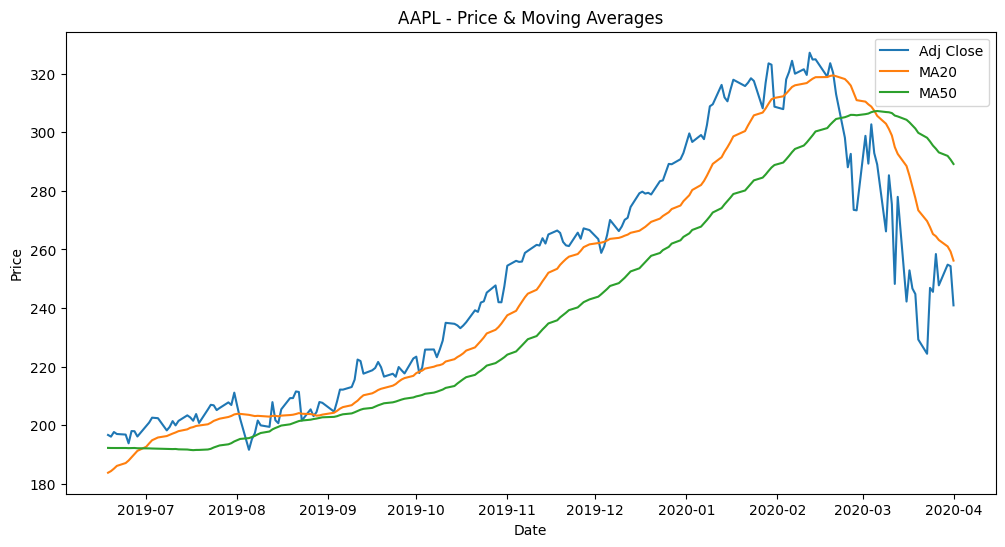

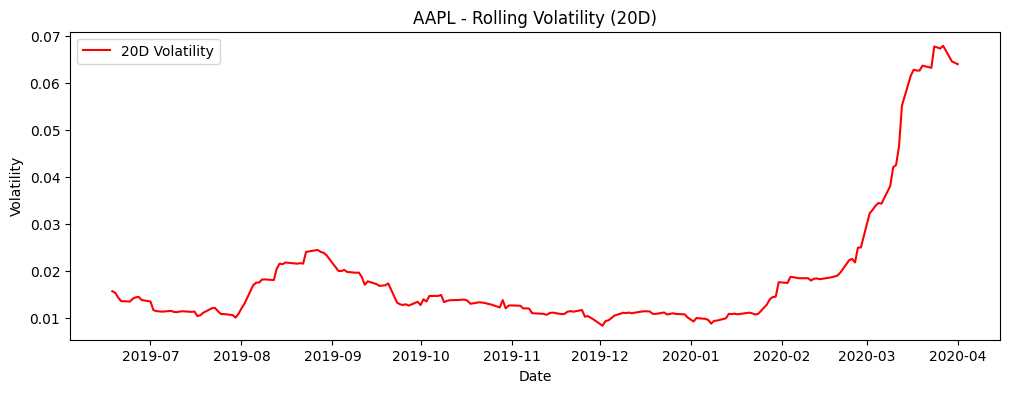

In [6]:
import matplotlib.pyplot as plt

# pick one ticker (e.g., AAPL)
aapl = stocks_df[stocks_df["Ticker"] == "AAPL"].dropna().tail(200)  # last ~200 days

plt.figure(figsize=(12,6))
plt.plot(aapl["Date"], aapl["Adj Close"], label="Adj Close")
plt.plot(aapl["Date"], aapl["MA20"], label="MA20")
plt.plot(aapl["Date"], aapl["MA50"], label="MA50")
plt.title("AAPL - Price & Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# volatility plot
plt.figure(figsize=(12,4))
plt.plot(aapl["Date"], aapl["Volatility20"], color="red", label="20D Volatility")
plt.title("AAPL - Rolling Volatility (20D)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()


In [7]:
from sklearn.preprocessing import StandardScaler

# aggregate by ticker
features = stocks_df.groupby("Ticker").agg({
    "Return": "mean",
    "Volatility20": "mean"
}).dropna()

features.columns = ["AvgReturn", "AvgVolatility"]

# scale features for clustering
scaler = StandardScaler()
X = scaler.fit_transform(features)

features.head()


,AvgReturn,AvgVolatility
Ticker,,
AAPL,0.001065,0.025665
AMZN,0.001880,0.031034
MSFT,0.001142,0.019048


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


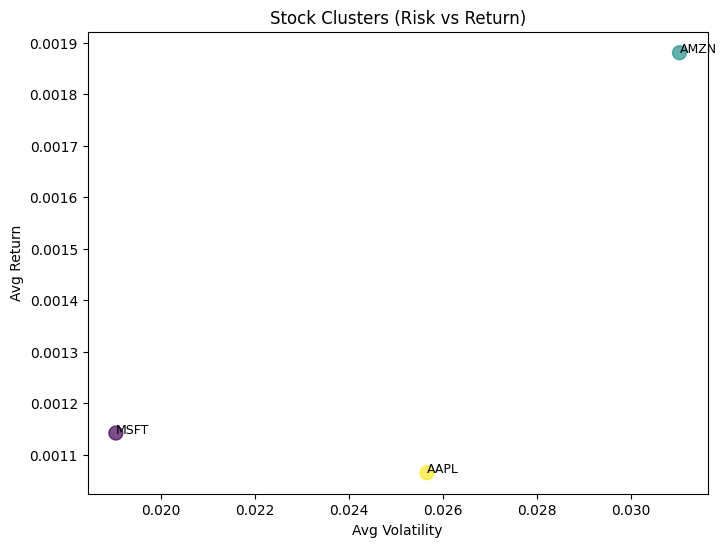

,AvgReturn,AvgVolatility,Cluster
Ticker,,,
AAPL,0.001065,0.025665,2
AMZN,0.001880,0.031034,1
MSFT,0.001142,0.019048,0


In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# fit k-means (let’s start with 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
features["Cluster"] = kmeans.fit_predict(X)

# visualize clusters
plt.figure(figsize=(8,6))
plt.scatter(features["AvgVolatility"], features["AvgReturn"], 
            c=features["Cluster"], cmap="viridis", s=100, alpha=0.7)
plt.xlabel("Avg Volatility")
plt.ylabel("Avg Return")
plt.title("Stock Clusters (Risk vs Return)")
for ticker, row in features.iterrows():
    plt.text(row["AvgVolatility"], row["AvgReturn"], ticker, fontsize=9)
plt.show()

features.head()


In [9]:
# Prepare mean returns and covariance matrix for the Monte Carlo simulation

# make sure data is sorted
stocks_df = stocks_df.sort_values(["Ticker", "Date"])

# average daily returns per ticker
mean_returns = stocks_df.groupby("Ticker")["Return"].mean()

# pivot returns into a wide format (tickers as columns) for covariance
returns_pivot = stocks_df.pivot(index="Date", columns="Ticker", values="Return")

# covariance matrix of returns
cov_matrix = returns_pivot.cov()

# check
print("Mean Returns:\n", mean_returns, "\n")
print("Covariance Matrix:\n", cov_matrix.head())


Mean Returns:
 Ticker
AAPL    0.001065
AMZN    0.001880
MSFT    0.001142
Name: Return, dtype: float64 

Covariance Matrix:
 Ticker      AAPL      AMZN      MSFT
Ticker                              
AAPL    0.000826  0.000313  0.000249
AMZN    0.000313  0.001397  0.000287
MSFT    0.000249  0.000287  0.000464


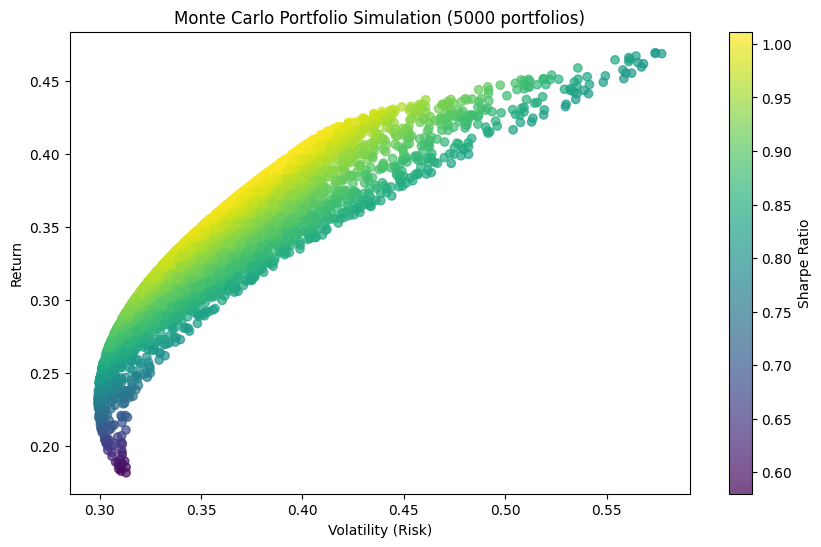

In [10]:
import numpy as np

# pick the tickers we clustered
tickers = ["AAPL", "MSFT", "AMZN"]
df = stocks_df[stocks_df["Ticker"].isin(tickers)].copy()

# calculate daily returns matrix
returns = df.pivot(index="Date", columns="Ticker", values="Adj Close").pct_change().dropna()

# number of simulations
n_portfolios = 5000
results = np.zeros((3, n_portfolios))

for i in range(n_portfolios):
    # random weights
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    
    # portfolio return
    port_return = np.sum(returns.mean() * weights) * 252
    
    # portfolio volatility
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    
    # sharpe ratio (risk-adjusted return, assume rf=0)
    sharpe = port_return / port_volatility
    
    results[0,i] = port_return
    results[1,i] = port_volatility
    results[2,i] = sharpe

# scatter plot portfolios
plt.figure(figsize=(10,6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap="viridis", alpha=0.7)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Return")
plt.title("Monte Carlo Portfolio Simulation (5000 portfolios)")
plt.show()


In [11]:
# --- Monte Carlo portfolios (rebuild correctly) ---
import numpy as np
import pandas as pd

np.random.seed(42)
n_portfolios = 5000

# mean_returns and cov_matrix must already be defined from earlier cells:
# mean_returns = stocks_df.groupby("Ticker")["Return"].mean()
# cov_matrix   = stocks_df.pivot(index="Date", columns="Ticker", values="Return").cov()
# tickers = ["AAPL", "MSFT", "AMZN"]

rets, vols, sharpes, weights_list = [], [], [], []

for _ in range(n_portfolios):
    w = np.random.random(len(tickers))
    w /= w.sum()
    weights_list.append(w)

    port_ret = float((w * mean_returns[tickers]).sum())
    port_vol = float(np.sqrt(w @ cov_matrix.loc[tickers, tickers].values @ w))

    rets.append(port_ret)
    vols.append(port_vol)
    sharpes.append(port_ret / port_vol if port_vol > 0 else np.nan)

results_df = pd.DataFrame({
    "Return": rets,
    "Volatility": vols,
    "SharpeRatio": sharpes
})
results_df["Weights"] = weights_list

results_df.head()


,Return,Volatility,SharpeRatio,Weights
0,0.001391,0.021910,0.063467,"[0.18205877561639985, 0.46212908544657766, 0.3..."
1,0.001218,0.023553,0.051698,"[0.657381271833743, 0.17132260711444883, 0.171..."
2,0.001430,0.022722,0.062931,"[0.03807825678154029, 0.5678448096745716, 0.39..."
3,0.001531,0.027467,0.055755,"[0.41686469204449644, 0.012118741982948326, 0...."
4,0.001199,0.023685,0.050621,"[0.6786548843400361, 0.1731109959235988, 0.148..."


In [12]:
# Cell X: Find and display the optimal portfolio (highest Sharpe ratio)

# locate the portfolio with the max Sharpe Ratio
max_sharpe_idx = results_df['SharpeRatio'].idxmax()
optimal_portfolio = results_df.loc[max_sharpe_idx]

print("📈 Optimal Portfolio Allocation:")
for ticker, weight in zip(tickers, optimal_portfolio['Weights']):
    print(f"{ticker}: {weight:.2%}")

print("\nExpected Annual Return:", f"{optimal_portfolio['Return']:.2%}")
print("Annual Volatility (Risk):", f"{optimal_portfolio['Volatility']:.2%}")
print("Sharpe Ratio:", f"{optimal_portfolio['SharpeRatio']:.2f}")


📈 Optimal Portfolio Allocation:
AAPL: 14.74%
MSFT: 54.70%
AMZN: 30.56%

Expected Annual Return: 0.14%
Annual Volatility (Risk): 2.12%
Sharpe Ratio: 0.06
